In [133]:
# %% Read data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

path = "GNNs2.csv"  # update if needed
df = pd.read_csv(path).rename(columns={"Unnamed: 3": "type"})

for c in ["val_auc_trade", "val_auc_dir", "test_auc_trade", "test_auc_dir"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["val_auc_trade"] = df["val_auc_trade"].fillna(0)

df["test_auc_trade"] = df["test_auc_trade"].fillna(0)


type_to_arrow = {"Post-CV check": "gray", "Full Refit check": "black"}

df[df["freq"] == "5min"]


,date,Model type,freq,type,pnl_sum,val_auc_trade,val_auc_dir,test_auc_trade,test_auc_dir
2,19.12.2025,GAT_pnl_15f2cl2s,5min,Post-CV check,0.0283,0.000,NaN,0.665,0.7420
3,17.12.2025,GLSTM_pnl3_15f2cl2s,5min,Post-CV check,0.1217,0.000,NaN,0.652,0.4640
4,17.12.2025,GNN_pnl2_15f2cl2s,5min,Post-CV check,0.0568476152,0.000,NaN,0.716,0.5660
5,17.12.2025,GNN_pnl_15f2cl2s,5min,Post-CV check,0.01533272228,0.000,NaN,0.664,0.6690
7,15.12.2025,GNN_8f2cl2stages,5min,Post-CV check,0.0005918935931,0.000,NaN,0.759,0.5840
8,15.12.2025,GNN_6f2cl2stages,5min,Post-CV check,0.02613251911,0.000,NaN,0.747,0.5610
9,15.12.2025,GNN_6f_2class,5min,Post-CV check,-,0.515,0.5280,0.000,NaN
10,04.12.2025,ftGNN4.0,5min,Post-CV check,-,0.000,0.5080,0.000,NaN
11,04.12.2025,ftGNN2.0,5min,Post-CV check,-,0.000,0.5120,0.000,NaN
12,04.12.2025,TGNN1.0,5min,Post-CV check,-,0.000,0.5300,0.000,0.5225


In [134]:


def add_ref_lines(ax):
    ax.axvline(0.5, lw=1.6, color="k", alpha=0.4, zorder=0.6)
    ax.axhline(0.5, lw=1.6, color="k", alpha=0.4, zorder=0.6)
    for v in [0.6, 0.7, 0.8, 0.9]:
        ax.axvline(v, lw=1.0, color="k", alpha=0.1, zorder=0.5)
        ax.axhline(v, lw=1.0, color="k", alpha=0.1, zorder=0.5)

def plot_freq(freq, df):
    d = df[df["freq"] == freq].copy()
    if d.empty:
        fig, ax = plt.subplots(figsize=(10, 7))
        add_ref_lines(ax)
        ax.set_title(f"{freq}: AUC trade vs AUC dir")
        ax.set_xlabel("auc_trade")
        ax.set_ylabel("auc_dir")
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.grid(True, alpha=0.25)
        plt.show()
        return

    for c in ["pnl_sum", "val_auc_trade", "val_auc_dir", "test_auc_trade", "test_auc_dir"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    pnl = d["pnl_sum"].fillna(0).to_numpy()
    pos = pnl[pnl > 0]
    pos_max = pos.max() if pos.size else 0.0

    def pnl_color(p):
        if p > 0 and pos_max > 0:
            return plt.cm.Greens(0.3 + 0.7 * min(p / pos_max, 1.0))
        return (0.8, 0.2, 0.2, 0.4)

    colors = [pnl_color(p) for p in pnl]

    x_val = d["val_auc_trade"].to_numpy()
    y_val = d["val_auc_dir"].to_numpy()
    x_tst = d["test_auc_trade"].to_numpy()
    y_tst = d["test_auc_dir"].to_numpy()

    has_test = np.isfinite(x_tst) & np.isfinite(y_tst)
    has_val = np.isfinite(x_val) & np.isfinite(y_val)
    has_arrow = has_test & has_val

    colors_tst = [colors[i] for i in np.where(has_test)[0]]

    fig, ax = plt.subplots(figsize=(10, 7))
    add_ref_lines(ax)

    ax.scatter(x_val, y_val, marker="o", s=90, c=colors, edgecolors="k", linewidths=0.4, zorder=3)
    ax.scatter(x_tst[has_test], y_tst[has_test], marker="s", s=90, c=colors_tst, edgecolors="k", linewidths=0.4, zorder=4)

    if np.any(has_arrow):
        for idx in np.where(has_arrow)[0]:
            r = d.iloc[idx]
            ax.annotate(
                "",
                xy=(float(r["test_auc_trade"]), float(r["test_auc_dir"])),
                xytext=(float(r["val_auc_trade"]), float(r["val_auc_dir"])),
                arrowprops=dict(arrowstyle="->", lw=1.2, color=type_to_arrow.get(r.get("type", None), "gray")),
                zorder=2,
            )

    if "Model type" in d.columns:
        for x, y, name in zip(x_val, y_val, d["Model type"].astype(str).to_list()):
            if np.isfinite(x) and np.isfinite(y):
                ax.text(x + 0.01, y + 0.01, name, fontsize=8)

    ax.set_title(f"{freq}: AUC trade vs AUC dir")
    ax.set_xlabel("auc_trade")
    ax.set_ylabel("auc_dir")
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.grid(True, alpha=0.25)

    ax.legend(
        handles=[
            Line2D([0], [0], marker="o", linestyle="None", markerfacecolor="white", markeredgecolor="k", label="val point"),
            Line2D([0], [0], marker="s", linestyle="None", markerfacecolor="white", markeredgecolor="k", label="test point"),
            Line2D([0], [0], color="gray", lw=1.2, label="Post-CV check arrow"),
            Line2D([0], [0], color="black", lw=1.2, label="Full Refit check arrow"),
        ],
        frameon=False,
        loc="lower right",
    )

    plt.show()


In [135]:
plot_freq("5min")

TypeError: plot_freq() missing 1 required positional argument: 'df'

In [ ]:

# %% Plot 1min
plot_freq("1min", df)


StopIteration: 

<Figure size 1000x700 with 1 Axes>

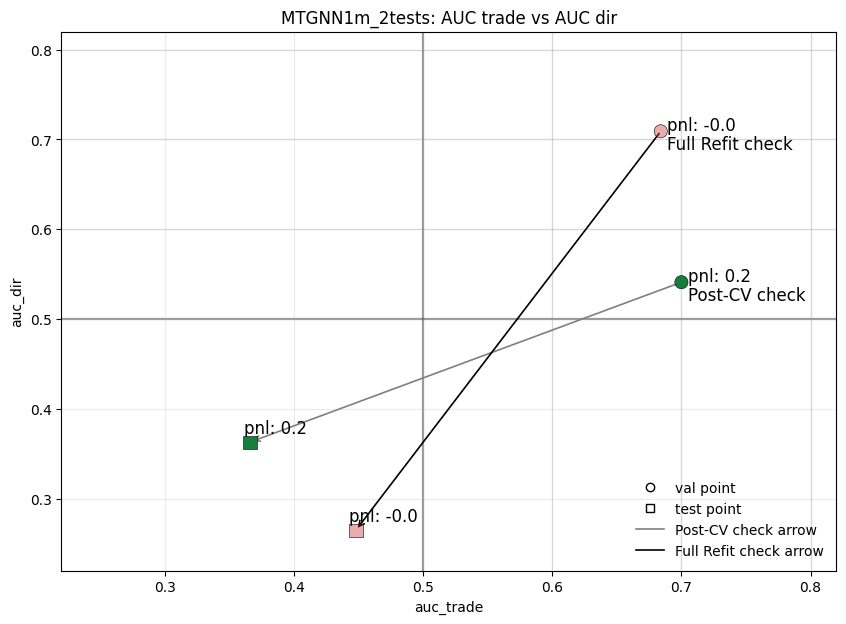

In [ ]:
names = ["MTGNN1m_2tests"]
xlim = [0.22, 0.82]
ylim = [0.22, 0.82]

d = df[df["Model type"].isin(names)].copy()
has_test = d["test_auc_dir"].notna()

pnl = pd.to_numeric(d["pnl_sum"], errors="coerce").fillna(0).to_numpy()
pos_max = pnl[pnl > 0].max() if np.any(pnl > 0) else 0.0

def pnl_color(p):
    if p > 0 and pos_max > 0:
        return plt.cm.Greens(0.3 + 0.5 * min(p / pos_max, 1.0))
    return (0.8, 0.2, 0.2, 0.4)

colors = [pnl_color(p) for p in pnl]

x_val, y_val = d["val_auc_trade"].to_numpy(), d["val_auc_dir"].to_numpy()
x_tst, y_tst = d.loc[has_test, "test_auc_trade"].to_numpy(), d.loc[has_test, "test_auc_dir"].to_numpy()
colors_tst = [colors[i] for i in np.where(has_test.to_numpy())[0]]

fig, ax = plt.subplots(figsize=(10, 7))
add_ref_lines(ax)

ax.scatter(x_val, y_val, marker="o", s=90, c=colors, edgecolors="k", linewidths=0.4, zorder=3)
ax.scatter(x_tst, y_tst, marker="s", s=90, c=colors_tst, edgecolors="k", linewidths=0.4, zorder=4)

for r in d.loc[has_test].itertuples(index=False):
    ax.annotate(
        "",
        xy=(r.test_auc_trade, r.test_auc_dir),
        xytext=(r.val_auc_trade, r.val_auc_dir),
        arrowprops=dict(arrowstyle="->", lw=1.2, color=type_to_arrow.get(r.type, "gray")),
        zorder=2,
    )

for x, y, name, pnl_text in zip(x_val, y_val, d["type"].astype(str).to_list(), d["pnl_sum"].to_list()):
    ax.text(x + 0.005, y - 0.02, name, fontsize=12)
    ax.text(x + 0.005, y + 0.001, f"pnl: {round(float(pnl_text),1)}", fontsize=12)

flag = 0
for x, y, name, pnl_text in zip(x_tst, y_tst, d["type"].astype(str).to_list(), d["pnl_sum"].to_list()):
    if flag <=2:
        ax.text(x - 0.005, y + 0.01, f"pnl: {round(float(pnl_text),1)}", fontsize=12)
        flag+=1
    else:
        ax.text(x - 0.005, y - 0.02, f"pnl: {round(float(pnl_text),1)}", fontsize=12)

ax.set_title(f"{names[0]}: AUC trade vs AUC dir")
ax.set_xlabel("auc_trade")
ax.set_ylabel("auc_dir")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.grid(True, alpha=0.25)

ax.legend(
    handles=[
        Line2D([0], [0], marker="o", linestyle="None", markerfacecolor="white", markeredgecolor="k", label="val point"),
        Line2D([0], [0], marker="s", linestyle="None", markerfacecolor="white", markeredgecolor="k", label="test point"),
        Line2D([0], [0], color="gray", lw=1.2, label="Post-CV check arrow"),
        Line2D([0], [0], color="black", lw=1.2, label="Full Refit check arrow"),
    ],
    frameon=False,
    loc="lower right",
)

plt.show()






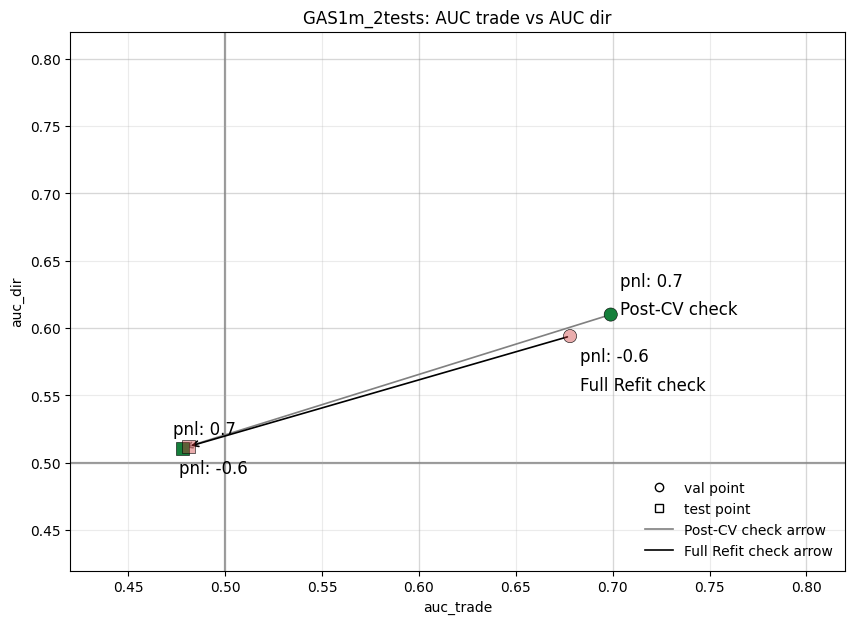

In [ ]:
names = ["GAS1m_2tests"]
xlim = [0.42, 0.82]
ylim = [0.42, 0.82]

d = df[df["Model type"].isin(names)].copy()
has_test = d["test_auc_dir"].notna()

pnl = pd.to_numeric(d["pnl_sum"], errors="coerce").fillna(0).to_numpy()
pos_max = pnl[pnl > 0].max() if np.any(pnl > 0) else 0.0

def pnl_color(p):
    if p > 0 and pos_max > 0:
        return plt.cm.Greens(0.3 + 0.5 * min(p / pos_max, 1.0))
    return (0.8, 0.2, 0.2, 0.4)

colors = [pnl_color(p) for p in pnl]

x_val, y_val = d["val_auc_trade"].to_numpy(), d["val_auc_dir"].to_numpy()
x_tst, y_tst = d.loc[has_test, "test_auc_trade"].to_numpy(), d.loc[has_test, "test_auc_dir"].to_numpy()
colors_tst = [colors[i] for i in np.where(has_test.to_numpy())[0]]

fig, ax = plt.subplots(figsize=(10, 7))
add_ref_lines(ax)

ax.scatter(x_val, y_val, marker="o", s=90, c=colors, edgecolors="k", linewidths=0.4, zorder=3)
ax.scatter(x_tst, y_tst, marker="s", s=90, c=colors_tst, edgecolors="k", linewidths=0.4, zorder=4)

for r in d.loc[has_test].itertuples(index=False):
    ax.annotate(
        "",
        xy=(r.test_auc_trade, r.test_auc_dir),
        xytext=(r.val_auc_trade, r.val_auc_dir),
        arrowprops=dict(arrowstyle="->", lw=1.2, color=type_to_arrow.get(r.type, "gray")),
        zorder=2,
    )
flag = 0
for x, y, name, pnl_text in zip(x_val, y_val, d["type"].astype(str).to_list(), d["pnl_sum"].to_list()):
    if flag <1:
        ax.text(x + 0.005, y , name, fontsize=12)
        ax.text(x + 0.005, y + 0.021, f"pnl: {round(float(pnl_text),1)}", fontsize=12)
        flag += 1
    else:
        ax.text(x + 0.005, y - 0.04, name, fontsize=12)
        ax.text(x + 0.005, y - 0.019, f"pnl: {round(float(pnl_text),1)}", fontsize=12)

flag = 0
for x, y, name, pnl_text in zip(x_tst, y_tst, d["type"].astype(str).to_list(), d["pnl_sum"].to_list()):
    if flag <1:
        ax.text(x - 0.005, y + 0.01, f"pnl: {round(float(pnl_text),1)}", fontsize=12)
        flag+=1
    else:
        ax.text(x - 0.005, y - 0.02, f"pnl: {round(float(pnl_text),1)}", fontsize=12)

ax.set_title(f"{names[0]}: AUC trade vs AUC dir")
ax.set_xlabel("auc_trade")
ax.set_ylabel("auc_dir")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.grid(True, alpha=0.25)

ax.legend(
    handles=[
        Line2D([0], [0], marker="o", linestyle="None", markerfacecolor="white", markeredgecolor="k", label="val point"),
        Line2D([0], [0], marker="s", linestyle="None", markerfacecolor="white", markeredgecolor="k", label="test point"),
        Line2D([0], [0], color="gray", lw=1.2, label="Post-CV check arrow"),
        Line2D([0], [0], color="black", lw=1.2, label="Full Refit check arrow"),
    ],
    frameon=False,
    loc="lower right",
)

plt.show()




